In [1]:
import os
import sys

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import custom_loss_functions
import utils
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from numpy import expand_dims

import requests
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import datetime
import csv
import pandas as pd
import json

import argparse

Using TensorFlow backend.


In [2]:
tf.__version__

'2.1.0'

In [3]:
keras.__version__

'2.2.4-tf'

In [4]:
if tf.config.list_physical_devices('GPU'):
    print("GPU was detected.")

GPU was detected.


# Load trained model

In [5]:
# model_path = "saved_models/MSE/04-02-2020_09:59:44/CAE_e100_b8_0"
# model_path = "saved_models/SSIM/05-02-2020_14:41:02/CAE_e150_b12_0.h5"
model_path = "saved_models/L2/05-02-2020_20:36:45/CAE_e150_b12_0.h5"

In [6]:
# import importlib
# importlib.reload(utils)

In [7]:
model, train_setup, history = utils.load_model_HDF5(model_path)

directory = train_setup["directory"]
val_data_dir = os.path.join(directory, "train")
color_mode = train_setup["color_mode"]
validation_split = train_setup["validation_split"]
channels = train_setup["channels"]
loss = train_setup["loss"]
batch_size = train_setup["batch_size"]

In [8]:
import pandas as pd

In [9]:
history[['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']].head(10)

,loss,mean_squared_error,val_loss,val_mean_squared_error
0,1.285454e+06,0.553779,96034.589286,0.488457
1,9.766576e+05,0.419944,64954.032552,0.330373
2,5.976475e+05,0.256824,31115.662853,0.158262
3,3.208629e+05,0.138614,19303.492281,0.098183
4,1.922974e+05,0.083099,14767.462286,0.075111
5,1.308216e+05,0.056393,13707.922108,0.069722
6,1.020153e+05,0.043977,8601.917783,0.043752
7,8.226308e+04,0.035439,7451.951358,0.037903
8,7.484484e+04,0.032246,7520.097145,0.038249
9,6.768545e+04,0.029152,6726.419294,0.034212


In [10]:
history = history[['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']]

In [11]:
history.head(20)

,loss,mean_squared_error,val_loss,val_mean_squared_error
0,1.285454e+06,0.553779,96034.589286,0.488457
1,9.766576e+05,0.419944,64954.032552,0.330373
2,5.976475e+05,0.256824,31115.662853,0.158262
3,3.208629e+05,0.138614,19303.492281,0.098183
4,1.922974e+05,0.083099,14767.462286,0.075111
5,1.308216e+05,0.056393,13707.922108,0.069722
6,1.020153e+05,0.043977,8601.917783,0.043752
7,8.226308e+04,0.035439,7451.951358,0.037903
8,7.484484e+04,0.032246,7520.097145,0.038249
9,6.768545e+04,0.029152,6726.419294,0.034212


In [12]:
history.tail(20)

,loss,mean_squared_error,val_loss,val_mean_squared_error
44,20657.850743,0.008902,1365.849807,0.006947
45,20960.248078,0.009023,1854.006784,0.009430
46,18488.905336,0.007966,1311.425560,0.006670
47,21493.757119,0.009305,1217.968012,0.006195
48,19829.972814,0.008572,1678.759801,0.008539
49,19471.248078,0.008440,1704.954468,0.008672
50,17594.960591,0.007589,1187.367548,0.006039
51,18497.832598,0.007958,1594.749715,0.008111
52,17700.590474,0.007740,1190.832328,0.006057
53,16017.064201,0.006901,1200.818220,0.006108


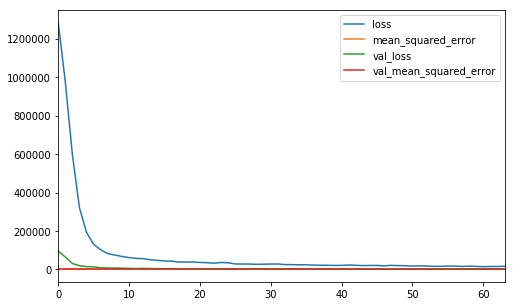

In [13]:
pd.DataFrame(history).plot(figsize=(8, 5))

## Predict on validation split (reconstruct defect-free validation images)

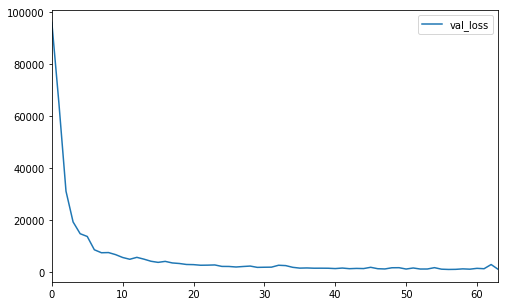

In [14]:
pd.DataFrame(history[['val_loss']]).plot(figsize=(8, 5))

In [15]:
# This will do preprocessing
validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255, validation_split=validation_split, zca_epsilon=1e-06,
)

# Generate validation batches with datagen.flow_from_directory()
validation_generator = validation_datagen.flow_from_directory(
    directory=val_data_dir,
    target_size=(256, 256),
    color_mode=color_mode,
    batch_size=1,
    shuffle=False,
    class_mode="input",
    subset="validation",
)

# Generate input-image batches with datagen.flow_from_directory()
input_generator = validation_datagen.flow_from_directory(
    directory=val_data_dir,
    target_size=(256, 256),
    color_mode=color_mode,
    batch_size=1,
    shuffle=False,
    class_mode="input",
    subset="validation",
)

Found 21 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


In [16]:
# retrieve preprocessed input images as a numpy array
nb_images = input_generator.samples
imgs_input = np.zeros(shape=(nb_images, 256, 256, channels))
for i in range(nb_images):
    img_input = input_generator.next()[0]
    imgs_input[i, :, :, :] = img_input

In [18]:
imgs_input.shape

(21, 256, 256, 3)

In [19]:
def plot_img(imgs, index):
    if imgs.shape[-1] == 3:
        plt.imshow(imgs[index])
    else:
        plt.imshow(imgs[index,:,:,0], cmap=plt.cm.gray)
    plt.show()

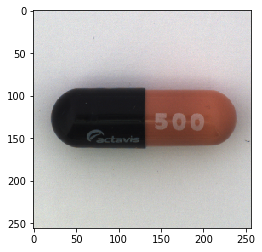

In [20]:
# plt.imshow(inputs[0]) # rgb
# plt.imshow(inputs[0,:,:,0], cmap=plt.cm.gray)
plot_img(imgs_input, 0)

--------------------------------------------------------------------------------------------------

### Inspect reconstructions through predict_generator

In [21]:
# get reconstructed images (predictions)
imgs_pred = model.predict_generator(
    validation_generator,
#     steps=validation_generator.samples / batch_size,
    steps=validation_generator.samples,
    verbose=1,
)

Instructions for updating:
Please use Model.predict, which supports generators.
21/21 [==============================] - 4s 168ms/step


In [22]:
imgs_pred.shape

(21, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


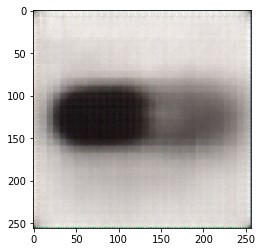

In [23]:
# plt.imshow(imgs_pred[20])
# plt.imshow(imgs_pred[0,:,:,0], cmap=plt.cm.gray)
plot_img(imgs_pred, index=0)

In [24]:
np.amax(imgs_pred)

1.0750525

In [25]:
np.amin(imgs_pred)

0.0281304

--------------------------------------------------------------------------------------------------

### Inspect reconstructions throught predict

In [36]:
imgs_pred = model.predict(imgs_input)

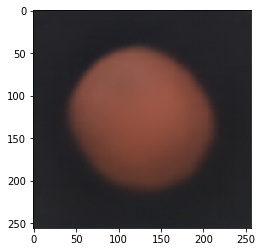

In [18]:
plt.imshow(imgs_pred[20])

In [27]:
np.amax(imgs_pred)

0.7803083

In [28]:
np.amin(imgs_pred)

0.10482304

--------------------------------------------------------------------------------------------------

In [32]:
imgs_diff = imgs_input - imgs_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


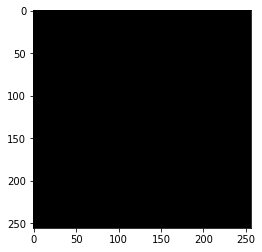

In [33]:
# plt.imshow(imgs_diff[20])
plot_img(imgs_diff, 0)

In [34]:
np.amax(imgs_diff)

5.9604645e-07

In [51]:
np.amin(imgs_diff)

-7.1525574e-07

--------------------------------------------------------------------------------------------------

---------------------------------------------------------

In [94]:
np.amin(imgs_inputs[0:1,:,:,:])

0.09019608050584793

In [71]:
from custom_loss_functions import mssim

In [107]:
batch_input = tf.convert_to_tensor(imgs_input[0:4,:,:,:], dtype=tf.float32) 
batch_pred = tf.convert_to_tensor(imgs_pred[0:4,:,:,:], dtype=tf.float32)

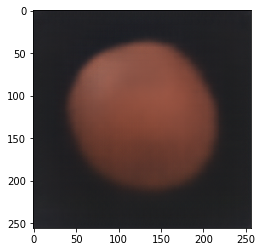

In [108]:
plt.imshow(batch_pred[0])

In [109]:
batch_input.shape

TensorShape([4, 256, 256, 3])

In [110]:
batch_pred.shape

TensorShape([4, 256, 256, 3])

In [111]:
test_tensor = tf.image.ssim_multiscale(batch_input, batch_pred, 1.0)

In [112]:
test_tensor.shape

TensorShape([4])

In [113]:
print(test_tensor)

tf.Tensor([0.87911576 0.90647703 0.8998406  0.890752  ], shape=(4,), dtype=float32)


In [133]:
print(tf.image.ssim_multiscale(batch_recon , batch_input, 1.0))

tf.Tensor([0.87911576 0.90647703 0.8998406  0.890752  ], shape=(4,), dtype=float32)


In [134]:
loss = (1 - K.mean(tf.image.ssim_multiscale(batch_input, batch_recon, 1.0), axis=-1))

In [135]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.105953634>

In [116]:
loss_mse = tf.keras.losses.MSE(
    batch_input,
    batch_recon
)

In [119]:
loss_mse.shape

TensorShape([4, 256, 256])

In [127]:
loss_mse.numpy().sum()

223.71962

In [129]:
loss_l2 = tf.nn.l2_loss(batch_input-batch_recon)

In [130]:
print(loss_l2)

tf.Tensor(335.5794, shape=(), dtype=float32)


In [74]:
test_tensor = mssim_loss(batch_input, batch_input)

In [75]:
type(test_tensor)

tensorflow.python.framework.ops.EagerTensor

In [76]:
test_tensor_np = test_tensor.numpy()

In [77]:
test_tensor_np.shape

()

### Compute residual maps

In [26]:
imgs_diff = imgs_input - imgs_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


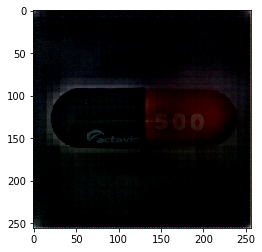

In [27]:
# plt.imshow(imgs_diff[0])
# plt.imshow(imgs_diff[0,:,:,0], cmap=plt.cm.gray)
plot_img(imgs_diff, index=0)

In [28]:
type(imgs_diff)

numpy.ndarray

In [29]:
imgs_diff_1d = imgs_diff.flatten()

(array([1.000000e+01, 1.250000e+02, 4.140000e+02, 2.401000e+03,
        9.092000e+03, 2.226600e+04, 4.329800e+04, 7.545500e+04,
        1.036520e+05, 1.592750e+05, 4.236970e+05, 9.932770e+05,
        1.072474e+06, 5.975080e+05, 2.533940e+05, 1.308020e+05,
        8.041000e+04, 5.042200e+04, 3.775400e+04, 2.766600e+04,
        1.977000e+04, 1.177500e+04, 5.160000e+03, 2.166000e+03,
        1.174000e+03, 8.650000e+02, 5.520000e+02, 3.310000e+02,
        2.460000e+02, 1.970000e+02, 1.640000e+02, 2.270000e+02,
        5.010000e+02, 5.890000e+02, 5.600000e+02, 6.340000e+02,
        3.300000e+02, 8.900000e+01, 3.600000e+01, 1.000000e+01]),
 array([-0.37826365, -0.34848088, -0.3186981 , -0.28891532, -0.25913254,
        -0.22934977, -0.19956699, -0.16978421, -0.14000143, -0.11021866,
        -0.08043588, -0.0506531 , -0.02087032,  0.00891245,  0.03869523,
         0.06847801,  0.09826078,  0.12804356,  0.15782634,  0.18760912,
         0.21739189,  0.24717467,  0.27695745,  0.30674023,  0.336

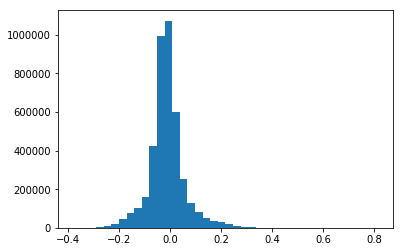

In [30]:
plt.hist(imgs_diff_1d, bins=40)

In [ ]:
hist = np.historgram(imgs_diff_1d)

In [42]:
val_data_dir

'mvtec/capsule/train'

In [ ]:
index = 1
plt.imshow(inputs[index])
img_original = tf.expand_dims(inputs[index], 0)
img_reconstruction = model.predict(img_original)
plt.imshow(img_reconstruction[0])